In [1]:
import pandas as pd
import tensorboard as tb
import seaborn as sns
import time
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
from pathlib import Path

In [2]:
# take every X sample for plot (raw log interval: 20k frames) default: 6
DATA_PLOT_SPARSITY = 100

# rolling average sample window (applied after sparsity) default: 4
DATA_PLOT_SMOOTHNESS = 4

MAX_TRAINING_STEPS = 20000000

# in and out dirs
logs_dir = Path.cwd() / Path("baselines_logs", "iscobots")
out_dir = Path.cwd() / Path("plots")

# envs to look for in logdir and subdirs and plot
envs = ["Bowling", "Tennis", "Pong", "Boxing", "Freeway"]

# experiments to exclude from plots:
dont_plot = []

# scalars to look for in tfevent files and plot
scalar_to_plot = {
    "tb_name" : "rollout/ep_rew_mean",
    "title" : "Human Normalized Return",
    "xlabel": "Frames (M)",
    "ylabel": "Score"}

# human baseline data per env
human_baselines = {
    "Pong" : 14.6,
    "Boxing" : 12.10,
    "Freeway" : 29.6, 
    "Asterix" : 8503.3,
    "Bowling" : 160.7,
    "Tennis" : -8.3
}

# random baseline data per env
random_baselines = {
    "Pong" : -20.7,
    "Boxing" : 0.10,
    "Freeway" : 0.00,
    "Asterix" : 210.0,
    "Bowling" : 23.1,
    "Tennis" : -23.8
}



In [3]:
for e in envs:
    try:
        human_baselines[e]
        random_baselines[e]
    except KeyError:
        print(f"Error: Baseline data missing for {e}")


def time_str(delta):
    x = str(delta).split(":")
    return f"{x[0]}h {x[1]}m {x[2]}s"
    

# for one env
def get_dfs_for_env(env, everyx=5, smooth_window=5):
    exp_list = []
    list_of_seed_dfs = []
    rand_score = random_baselines[env]
    hn_score = human_baselines[env]
    #print(logs_dir)
    for p in logs_dir.rglob("*"):
        if p.is_file():
            if env in str(p.parents[0].name):
                split_name = p.parents[0].name.split("_")
                seed = split_name[1][1:]
                exp_name = split_name[0]
                if p.parents[0].name in dont_plot:
                    continue
                exp_list.append((seed, p.parents[0]))
    exp_list = set(exp_list) # remove duplicates
    if len(exp_list) == 0:
        return None
    exp_str_list = [int(n[0]) for n in exp_list]

    
    # constructs data_dict as follows:
    # {seed : [(tag, s.step, s.value, seed),...]}
    data_dict = {}
    for seed, log_dir in exp_list:
        max_step  = 0
        max_wt = 0
        curve_id = env
        for file in log_dir.iterdir():
            if 'tfevents' in file.name:
                acc = ea.EventAccumulator(str(file))
                acc.Reload()
                scalar_list = acc.Tags()['scalars']                        
                key = seed
                for tag in scalar_list:
                    for s in acc.Scalars(tag):
                        if not key in data_dict.keys():
                            data_dict[key] = []
                        data_dict[key].append((tag, s.step, s.value, seed, curve_id, s.wall_time))
                        max_step = s.step if max_step < s.step else max_step
                        max_wt = s.wall_time if max_wt < s.wall_time else max_wt

    # extracts scalar samples from df,
    # processes them (cleaning, skipping and smoothing)
    # and returnsnew df
    def extract_scalar_df(df):
        s = scalar_to_plot["tb_name"]
        scalar_df = df[df["tag"] == s].copy()            
        scalar_df = scalar_df.sort_values(by=["step", "wall_time"], ascending=True)
        scalar_df = scalar_df.drop_duplicates(subset=['step'], keep="last")
        scalar_df = scalar_df.iloc[::everyx, :]
        scalar_df["value"] = scalar_df.value.rolling(smooth_window, min_periods=1).mean()
        return scalar_df[["step", "value", "seed", "curve_id"]]
    
    # for every seed 
    for k, v in data_dict.items():
        df = pd.DataFrame(v, columns=["tag", "step", "value", "seed", "curve_id", "wall_time"])
        df.step = df.step / 1000000
        list_of_seed_dfs.append(extract_scalar_df(df))
    
    # last avg return
    last_returns = ([l.iloc[-1]["value"] for l in list_of_seed_dfs])
    env_avg = np.average(last_returns)
    env_std = np.std(last_returns)
    # merge seed df's to one df, inplace
    all_df = pd.concat(list_of_seed_dfs, ignore_index=True)
    #human normalized
    all_df["value"] = all_df["value"].apply(lambda x : (x - rand_score)/(hn_score - rand_score))
    print(f"{env} : {sorted(exp_str_list)}    Avg return: {env_avg:.2f} std: {env_std:.2f}")
    return all_df

In [4]:
data_to_plot = {}

# goes over every specified env and
# creates dict: {env : df, env2 : df, ...}
print(f"Parsing TB Logs for {len(envs)} envs..")
for e in envs:
    res_df = get_dfs_for_env(e, DATA_PLOT_SPARSITY, DATA_PLOT_SMOOTHNESS)
    #print(res_df)
    if res_df is not None:
        data_to_plot[e] = res_df

Parsing TB Logs for 5 envs..
Bowling : [0, 16, 32]    Avg return: 23.88 std: 1.49
Pong : [0, 16, 32]    Avg return: 12.54 std: 2.15
Boxing : [0, 16, 32]    Avg return: 68.14 std: 2.83
Freeway : [0, 16, 32]    Avg return: 24.35 std: 1.00


In [8]:
data_to_plot.values()

dict_values([          step     value seed curve_id
0     0.034816 -0.001181    0  Bowling
1     0.239616  0.015652    0  Bowling
2     0.444416  0.030227    0  Bowling
3     0.649216  0.043037    0  Bowling
4     0.854016  0.063536    0  Bowling
..         ...       ...  ...      ...
289  19.081216  0.096966   32  Bowling
290  19.286016  0.097438   32  Bowling
291  19.490816  0.098583   32  Bowling
292  19.695616  0.099491   32  Bowling
293  19.900416  0.100672   32  Bowling

[294 rows x 4 columns],           step     value seed curve_id
0     0.026624 -0.012903    0   Tennis
1     0.231424 -0.009677    0   Tennis
2     0.436224 -0.007957    0   Tennis
3     0.641024 -0.003387    0   Tennis
4     0.845824  0.021613    0   Tennis
..         ...       ...  ...      ...
289  19.073024  0.973226   16   Tennis
290  19.277824  0.963548   16   Tennis
291  19.482624  0.956613   16   Tennis
292  19.687424  0.950161   16   Tennis
293  19.892224  0.947419   16   Tennis

[294 rows x 4 columns],  

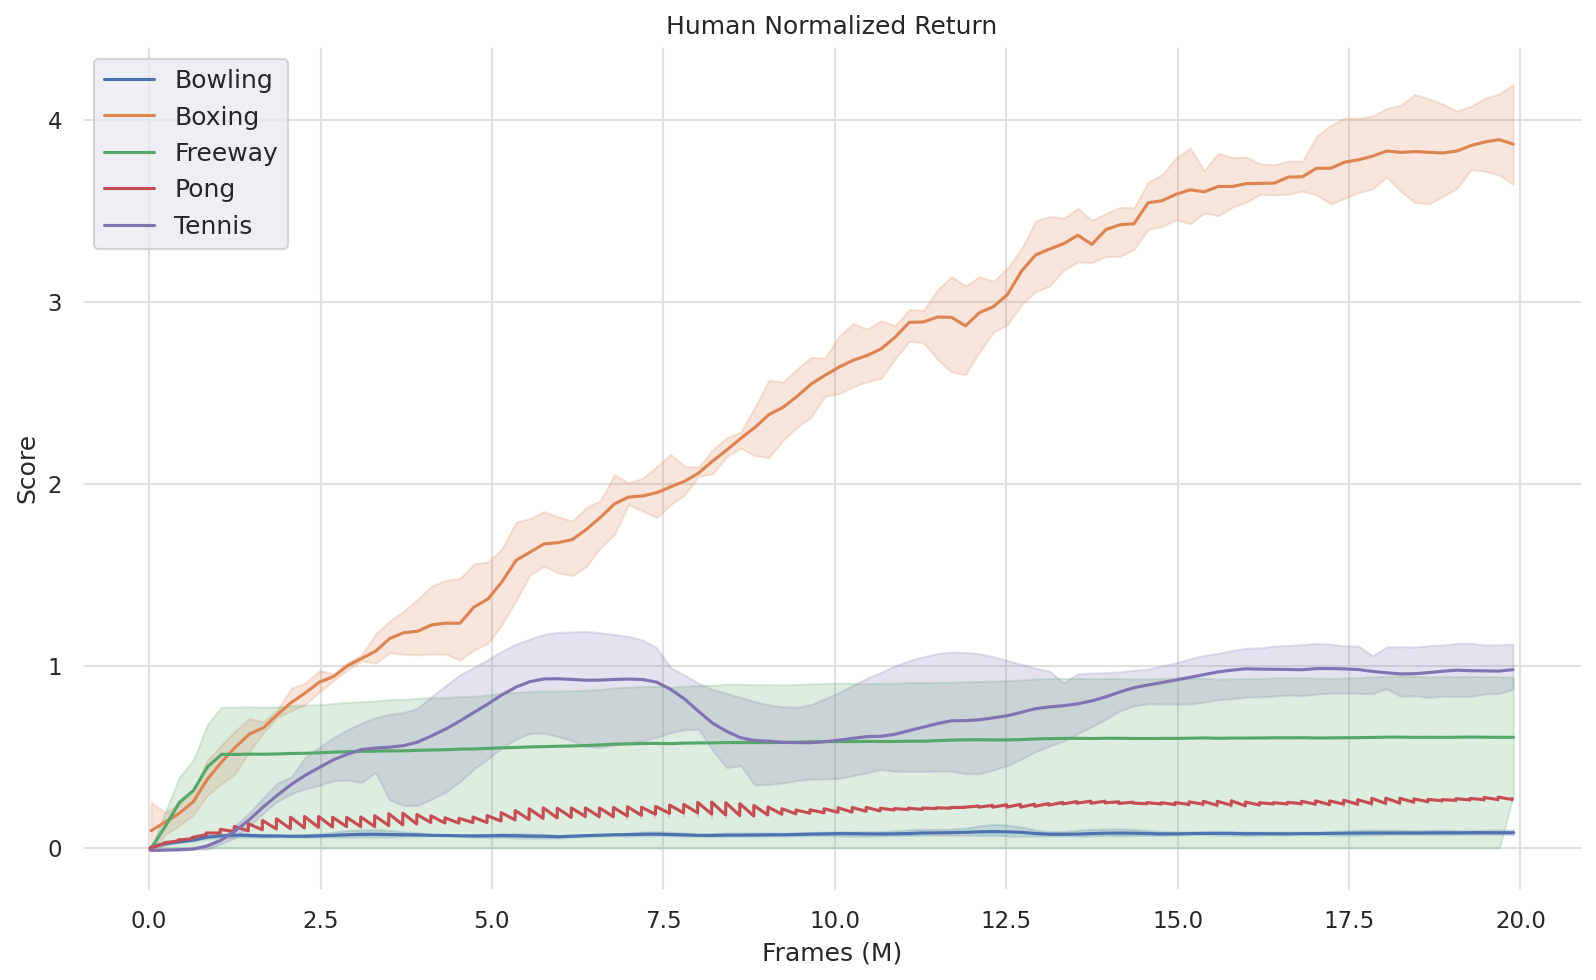

In [9]:
sns.set_theme()
fig_size = (10, 7.5)
fig = plt.figure(figsize=fig_size, dpi=150)

data = pd.concat(list(data_to_plot.values()), ignore_index=True)
data.to_pickle("out.pkl")
data.to_csv("out.csv")
order = sorted(data["curve_id"].unique())
ax = sns.lineplot(data=data, x="step", y="value", hue="curve_id", hue_order=order)
ax.set_facecolor('white')
ax.grid(color='#e0e0e0', linestyle='-', linewidth=1)
ax.set(
    xlabel = scalar_to_plot["xlabel"],
    ylabel = scalar_to_plot["ylabel"],
    title  = scalar_to_plot["title"])
ax.legend(loc='upper left', fontsize=12)
plt.subplots_adjust(top = 0.9, bottom=0.15, left=0, right=1)
plt.show(fig)
fig.savefig(out_dir / "results.png", bbox_inches='tight')